# Training Deep Networks without Learning Rates Through Coin Betting

As part of the [Global NIPS paper implementation challenge](https://nurture.ai/nips-challenge), I am implementing this paper: https://arxiv.org/abs/1705.07795 in PyTorch.

Submitter:

* Name: Anand Saha (anandsaha@gmail.com)
* Blog: http://teleported.in/
* LinkedIn: https://www.linkedin.com/in/anandsaha/

**For my evaluation, I will be implementing all code in PyTorch 3.**

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils
import torch.utils.data
import torch.nn.functional as F
import torch.distributions as distributions

from torchvision import datasets, transforms
from torchvision import models
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt

%matplotlib inline

### Global constants

In [2]:
num_epochs = 30
bs = 100
mnist_dim = 28 * 28
mnist_num_classes = 10
cifar10_dim = 32 * 32
cifar10_num_classes = 10

In [3]:
optimizers = ['adagrad', 'rmsprop', 'adadelta', 'adam', 'cocob']

In [4]:
colors = dict()
colors['cocob'] = 'red'
colors['adam'] = 'black'
colors['adadelta'] = 'blue'
colors['rmsprop'] = 'magenta'
colors['adagrad'] = 'green'

In [5]:
import pickle

def save_data(fname, l):
    with open(fname, "wb") as fp:
        pickle.dump(l, fp)
        
def read_datat(fname):
    with open(fname, "rb") as fp:
        return pickle.load(fp)

## 1: Create the COCOB-Backprop optimizer

The paper shows results with this optimizer, as outlined in Algorithm 2.

From the paper: _We implemented COCOB (following Algorithm 2) in Tensorflow [Abadi et al., 2015] and we used the
implementations of the other algorithms provided by this deep learning framework._


Loading file from cocob.py:

In [6]:
# %load cocob.py
import torch.optim as optim
import torch

###########################################################################
# Training Deep Networks without Learning Rates Through Coin Betting
# Paper: https://arxiv.org/abs/1705.07795
#
# NOTE: This optimizer is hardcoded to run on GPU, needs to be parametrized
###########################################################################

class COCOBBackprop(optim.Optimizer):
    
    def __init__(self, params, alpha=100, epsilon=1e-8):
        
        self._alpha = alpha
        self.epsilon = epsilon
        defaults = dict(alpha=alpha, epsilon=epsilon)
        super(COCOBBackprop, self).__init__(params, defaults)
        
    def step(self, closure=None):
        
        loss = None
        
        if closure is not None:
            loss = closure()
            
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
        
                grad = p.grad.data
                state = self.state[p]
                
                if len(state) == 0:
                    state['gradients_sum'] = torch.zeros_like(p.data).cuda().float()
                    state['grad_norm_sum'] = torch.zeros_like(p.data).cuda().float()
                    state['L'] = self.epsilon * torch.ones_like(p.data).cuda().float()
                    state['tilde_w'] = torch.zeros_like(p.data).cuda().float()
                    state['reward'] = torch.zeros_like(p.data).cuda().float()
                    
                gradients_sum = state['gradients_sum']
                grad_norm_sum = state['grad_norm_sum']
                tilde_w = state['tilde_w']
                L = state['L']
                reward = state['reward']
                
                zero = torch.cuda.FloatTensor([0.])
                
                L_update = torch.max(L, torch.abs(grad))
                gradients_sum_update = gradients_sum + grad
                grad_norm_sum_update = grad_norm_sum + torch.abs(grad)
                reward_update = torch.max(reward - grad * tilde_w, zero)
                new_w = -gradients_sum_update/(L_update * (torch.max(grad_norm_sum_update + L_update, self._alpha * L_update)))*(reward_update + L_update)
                p.data = p.data - tilde_w + new_w
                tilde_w_update = new_w
                
                state['gradients_sum'] = gradients_sum_update
                state['grad_norm_sum'] = grad_norm_sum_update
                state['L'] = L_update
                state['tilde_w'] = tilde_w_update
                state['reward'] = reward_update

        return loss


## 2: Create the models to experiment on

Some common helper modules first:

In [31]:
def weights_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.normal(m.weight.data, mean=0.0, std=0.1)
        torch.nn.init.constant(m.bias.data, 0.1)
        
def weights_init_cifar10(m, std, mean=0.0, bias=0.0):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_normal(m.weight.data)
        torch.nn.init.constant(m.bias.data, bias)

In [8]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

LRN from https://github.com/jiecaoyu/pytorch_imagenet/blob/master/networks/model_list/alexnet.py

**Task:** `Digits Recognition with MNIST`

From the paper: _For the first network we reproduce the structure described in the multi-layer experiment of [Kingma and Ba, 2015]: it has two fully connected hidden layers with 1000 hidden units each and ReLU activations, with mini-batch size of 100. The weights are initialized with a centered truncated normal distribution and standard deviation 0.1, the same small value 0.1 is also used as initialization for the bias._

In [9]:
class FC(nn.Module):
    
    def __init__(self, d_in, d_hidden, d_out):
        super().__init__()
        
        self.linear1 = torch.nn.Linear(d_in, d_hidden, bias=True)
        self.linear2 = torch.nn.Linear(d_hidden, d_hidden, bias=True)
        self.linear3 = torch.nn.Linear(d_hidden, d_out, bias=True)
        
    def forward(self, input):
        out = F.relu(self.linear1(input))
        out = F.relu(self.linear2(out))
        logits = self.linear3(out)
        return logits

From the paper: _The CNN architecture follows the [Tensorflow tutorial 4](https://github.com/tensorflow/tensorflow/blob/r1.4/tensorflow/examples/tutorials/mnist/mnist%5fdeep.py): two alternating stages of 5 × 5 convolutional filters and 2 × 2 max pooling are followed by a fully connected layer of 1024 rectified linear units (ReLU). To reduce overfitting, 50% dropout noise is used during training._

In [10]:
class CNN_MNIST(nn.Module):
    """Expects 28x28x1 images"""
    
    def __init__(self, in_channel=1):
        super(CNN_MNIST, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel, 32, kernel_size=5, bias=True, padding=(2, 2)), # SAME padding
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2))
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, bias=True, padding=(2, 2)),         # SAME padding 
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2))
        
        self.fc = nn.Sequential(
            Flatten(),
            nn.Linear(7*7*64, 1024, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 10, bias=True))
        
    def forward(self, input):
        out = self.conv1(input)
        out = self.conv2(out)
        out = self.fc(out)
        return out

**Task:** `Object Classification with CIFAR-10`

From the paper: _For this task we used the network defined in the [Tensorflow CNN tutorial](https://github.com/tensorflow/models/blob/master/tutorials/image/cifar10/cifar10.py). It starts with two convolutional layers with 64 kernels of dimension 5 × 5 × 3, each followed by a 3 × 3 × 3 max pooling
with stride of 2 and by local response normalization as in Krizhevsky et al. [2012]. Two more fully connected
layers respectively of 384 and 192 rectified linear units complete the architecture that ends with a standard
softmax cross-entropy classifier. We use a batch size of 128 and the input images are simply pre-processed
by whitening. Differently from the Tensorflow tutorial, we do not apply image random distortion for data
augmentation._

In [32]:
class CNN_CIFAR10(nn.Module):
    """Expects 32x32x3 images"""
    
    def __init__(self, in_channel=3):
        super(CNN_CIFAR10, self).__init__()
       
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel, 64, kernel_size=5, bias=True, padding=(2, 2)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2))
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=5, bias=True, padding=(2, 2)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2))
        
        self.local1 = nn.Sequential(
            Flatten(),
            nn.Linear(7*7*64, 384, bias=True),
            nn.ReLU())
        
        self.local2 = nn.Sequential(
            nn.Linear(384, 192, bias=True),
            nn.ReLU())
        
        self.fc = nn.Sequential(
            nn.Linear(192, 10, bias=True),
            )
        
        weights_init_cifar10(self.conv1, 5e-2, 0.0, 0.0)
        weights_init_cifar10(self.conv2, 5e-2, 0.0, 0.1)
        weights_init_cifar10(self.local1, 0.04, 0.0, 0.1)
        weights_init_cifar10(self.local2, 0.04, 0.0, 0.1)
        weights_init_cifar10(self.fc, 1/192.0, 0.0, 0.0)
        
        
    def forward(self, input):
        out = self.conv1(input)
        out = self.conv2(out)
        out = self.local1(out)
        out = self.local2(out)
        logits = self.fc(out)
        return logits

**Task:** `Word-level Prediction with RNN on Penn Tree Bank`

From the paper: _We adopted the
medium LSTM [Hochreiter and Schmidhuber, 1997] network architecture described in Zaremba et al. [2014]:
it has 2 layers with 650 units per layer and parameters initialized uniformly in [−0.05, 0.05], a dropout of
50% is applied on the non-recurrent connections, and the norm of the gradients (normalized by mini-batch
size = 20) is clipped at 5._

Original model: https://github.com/wojzaremba/lstm

For my testing, I used the [word_language_model](https://github.com/pytorch/examples/tree/master/word_language_model) from PyTorch examples. I downloaded the `word_language_model/` folder into this repository and made some simple changes to capture stats and have the comparison going.

## 3: Create the training routine and helper functions

In [12]:
def run(num_epochs, bs, model, optimizer, criteria, dl_train, dl_val, 
        flatten=False, verbose=False):
    
    train_loss = list()
    train_err = list()
    valid_loss = list()
    valid_err = list()
    
    for epoch in range(num_epochs):
        
        # Train
        model.train()
        running_loss = 0.0
        correct = 0
        i = 0
        for idx, (data, target) in enumerate(dl_train):
            data = data.cuda()
            if flatten:
                data = data.view(bs, -1)
            data, target = Variable(data), Variable(target.cuda())
            optimizer.zero_grad()
            output = model(data)
            loss = criteria(output, target)
            running_loss += loss.data[0]
            loss.backward()
            optimizer.step()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cuda().sum()
            i += 1
        
        epoch_train_loss = running_loss / i
        tra_err = 1. - correct / len(dl_train.dataset)
        train_loss.append(epoch_train_loss)
        train_err.append(tra_err)
            
        # Validate
        model.eval()
        running_loss = 0.0
        correct = 0
        i = 0
        for idx, (data, target) in enumerate(dl_val):
            data = data.cuda()
            if flatten:
                data = data.view(bs, -1)
            data, target = Variable(data), Variable(target.cuda())
            optimizer.zero_grad()
            output = model(data)
            loss = criteria(output, target)
            running_loss += loss.data[0]
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cuda().sum()
            i += 1
        
        epoch_val_loss = running_loss / i
        val_err = 1. - correct / len(dl_val.dataset)
        valid_loss.append(epoch_val_loss)
        valid_err.append(val_err)
        
        #print(epoch, ' ', end='')
        print('.', end='')
        
        if verbose:
            print('Ep #: {}, Tr loss: ({:.4f}), Tr err: ({:.4f}), Val loss: ({:.4f}), Val err: ({:.4f})'.format(epoch, epoch_train_loss, tra_err, epoch_val_loss, val_err))

    return train_loss, train_err, valid_loss, valid_err


In [13]:
def run_experiment(num_epochs, bs, model, opt, opt_name, dl_train, dl_val, flatten, verbose):
    start = time.time()
    print('Running ', opt_name)
    criteria = nn.CrossEntropyLoss()
    result = run(num_epochs, bs, model, opt, criteria, dl_train, dl_val, flatten, verbose)
    print('Done in {:.2f} secs'.format(time.time() - start))
    return result

In [54]:
def plot_graphs_all(results, colors, heading):
    f, axarr = plt.subplots(2, 2)
    
    for name in results:
        axarr[0, 0].semilogy(results[name][0], c=colors[name], label=name)
        axarr[0, 1].semilogy(results[name][1], c=colors[name], label=name)
        axarr[1, 0].semilogy(results[name][2], c=colors[name], label=name)
        axarr[1, 1].semilogy(results[name][3], c=colors[name], label=name)
        
    axarr[0, 0].set_title('Train Cost')
    axarr[0, 0].legend()
    axarr[0, 1].set_title('Train Err')
    axarr[0, 1].legend()
    axarr[1, 0].set_title('Validation Cost')
    axarr[1, 0].legend()
    axarr[1, 1].set_title('Validation Err')
    axarr[1, 1].legend()
    
    f.set_size_inches(15, 10)
    plt.legend()
    plt.suptitle(heading, fontsize=16)
    plt.show()

def plot_graphs(results, colors, heading):
    f, axarr = plt.subplots(1, 2)
    
    for name in results:
        axarr[0].semilogy(results[name][0], c=colors[name], label=name)
        axarr[1].semilogy(results[name][1], c=colors[name], label=name)
        
    axarr[0].set_title('Train Cost')
    axarr[0].legend()
    axarr[1].set_title('Train Err')
    axarr[1].legend()
    
    f.set_size_inches(15, 6)
    plt.legend()
    plt.suptitle(heading, fontsize=16)
    plt.show()


## 4: Prepare the datasets

**`MNIST Dataset`**

In [15]:
def get_mnist(bs):
    kwargs = {'num_workers': 4, 'pin_memory': True}
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

    ds_mnist_train = datasets.MNIST('data', train=True, download=True, transform=transform)
    ds_mnist_val  = datasets.MNIST('data', train=False, download=True, transform=transform)

    dl_mnist_train = torch.utils.data.DataLoader(ds_mnist_train, batch_size=bs, shuffle=True, **kwargs)
    dl_mnist_val = torch.utils.data.DataLoader(ds_mnist_val, batch_size=bs, shuffle=True, **kwargs)
    
    return dl_mnist_train, dl_mnist_val


**`CIFAR-10 Dataset`**

In [16]:
def get_cifar10(bs):
    kwargs = {'num_workers': 4, 'pin_memory': True}
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])


    ds_cifar10_train = datasets.CIFAR10('data', train=True, download=True, transform=transform)
    ds_cifar10_val  = datasets.CIFAR10('data', train=False, download=True, transform=transform)

    dl_cifar10_train = torch.utils.data.DataLoader(ds_cifar10_train, batch_size=bs, shuffle=True, **kwargs)
    dl_cifar10_val = torch.utils.data.DataLoader(ds_cifar10_val, batch_size=bs, shuffle=True, **kwargs)
    return dl_cifar10_train, dl_cifar10_val


**`Penn Tree Bank`**

In [17]:
import os
import urllib
import shutil

url  = 'http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz '
file = 'data/simple-examples.tgz'
    
if not os.path.exists(file):
    with urllib.request.urlopen(url) as response, open(file, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
else:
    print('File already downloaded')
    
!tar -xf data/simple-examples.tgz -C data
print('Finished untaring file')

File already downloaded
Finished untaring file


## 5: Run the experiments

In [18]:
def get_optimizer(model, opt_name, lr=None):
    
    if lr is None:
        lr = {'adagrad': 0.0075, 'rmsprop': 0.001, 'adadelta': 0.1, 'adam': 0.0001}
    
    if opt_name == 'adagrad':
        print('Constructing', opt_name)
        return optim.Adagrad(model.parameters(), lr=lr[opt_name])
    if opt_name == 'rmsprop':
        print('Constructing', opt_name)
        return optim.RMSprop(model.parameters(), lr=lr[opt_name])
    if opt_name == 'adadelta':
        print('Constructing', opt_name)
        return optim.Adadelta(model.parameters(), lr=lr[opt_name])
    if opt_name == 'adam':
        print('Constructing', opt_name)
        return optim.Adam(model.parameters(), lr=lr[opt_name])
    if opt_name == 'cocob':
        print('Constructing', opt_name)
        return COCOBBackprop(model.parameters())
    
    raise Exception("Optimizer '{}' not supported".format(opt_name))
    

**Task: `Digits Recognition with MNIST`, with fully connected model**


Constructing adagrad
Running  adagrad
........................................Done in 60.15 secs
Constructing rmsprop
Running  rmsprop
........................................Done in 60.30 secs
Constructing adadelta
Running  adadelta
........................................Done in 66.30 secs
Constructing adam
Running  adam
........................................Done in 61.65 secs
Constructing cocob
Running  cocob
........................................Done in 93.74 secs


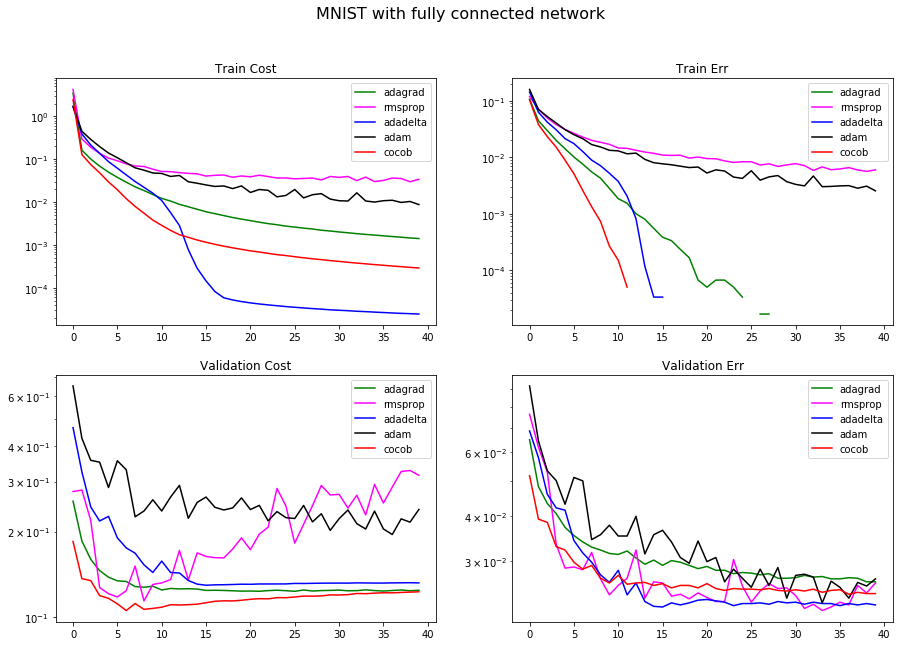

In [19]:
bs=100
num_epochs = 40
dl_train, dl_val = get_mnist(bs)
results_1 = dict()

for opt_name in optimizers:
    model = FC(d_in=mnist_dim, d_hidden=1000, d_out=mnist_num_classes).cuda()
    model.apply(weights_init)
    opt = get_optimizer(model, opt_name)
    result = run_experiment(num_epochs, bs, model, opt, opt_name, dl_train, dl_val, flatten=True, verbose=False)
    results_1[opt_name] = result

plot_graphs_all(results_1, colors, 'MNIST with fully connected network')

**Task: `Digits Recognition with MNIST`, using CNN based model**

Constructing adagrad
Running  adagrad
........................................Done in 112.79 secs
Constructing rmsprop
Running  rmsprop
........................................Done in 115.27 secs
Constructing adadelta
Running  adadelta
........................................Done in 128.51 secs
Constructing adam
Running  adam
........................................Done in 120.97 secs
Constructing cocob
Running  cocob
........................................Done in 188.70 secs


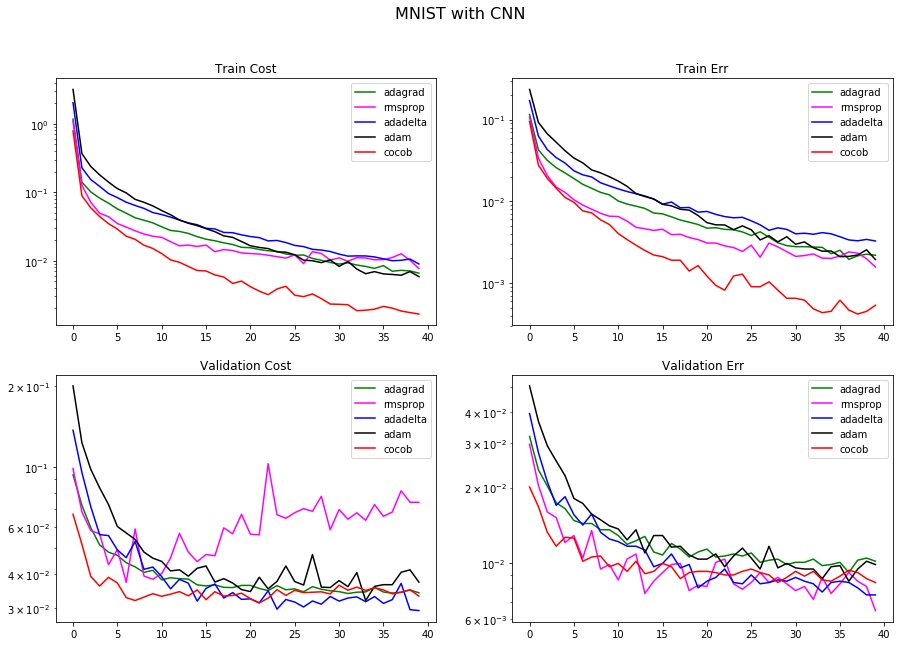

In [20]:
bs=100
num_epochs = 40
dl_train, dl_val = get_mnist(bs)
results_2 = dict()

for opt_name in optimizers:
    model = CNN_MNIST().cuda()
    model.apply(weights_init)
    opt = get_optimizer(model, opt_name)
    result = run_experiment(num_epochs, bs, model, opt, opt_name, dl_train, dl_val, flatten=False, verbose=False)
    results_2[opt_name] = result
    
plot_graphs_all(results_2, colors, 'MNIST with CNN')

**Task: `Object Classification with CIFAR-10`, using CNN based model**

Files already downloaded and verified
Files already downloaded and verified
Constructing adagrad
Running  adagrad
....................................................................................................Done in 471.64 secs
Constructing rmsprop
Running  rmsprop
....................................................................................................Done in 472.48 secs
Constructing adadelta
Running  adadelta
....................................................................................................Done in 494.63 secs
Constructing adam
Running  adam
....................................................................................................Done in 480.96 secs
Constructing cocob
Running  cocob
....................................................................................................Done in 631.81 secs


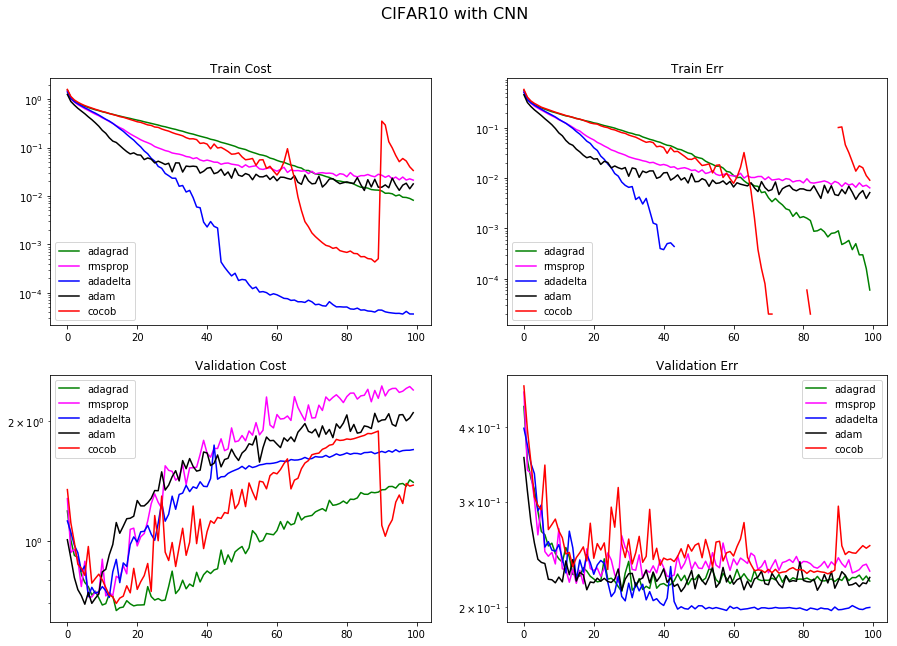

In [33]:
bs=100
num_epochs = 100
dl_train, dl_val = get_cifar10(bs)
results_3 = dict()
lr = {'adagrad': 0.01, 'rmsprop': 0.001, 'adadelta': 0.1, 'adam': 0.001}

for opt_name in optimizers:
    model = CNN_CIFAR10().cuda()
    opt = get_optimizer(model, opt_name, lr=lr)
    result = run_experiment(num_epochs, bs, model, opt, opt_name, dl_train, dl_val, flatten=False, verbose=False)
    results_3[opt_name] = result
plot_graphs_all(results_3, colors, 'CIFAR10 with CNN')

In [22]:
save_data('result_1.pkl', results_1)
save_data('result_2.pkl', results_2)
save_data('result_3.pkl', results_3)

### Other Experiments

Trying CIFAR with a bigger batch size. We observe that COCOB is overfitting:

Files already downloaded and verified
Files already downloaded and verified
Constructing adagrad
Running  adagrad
....................................................................................................Done in 348.13 secs
Constructing rmsprop
Running  rmsprop
....................................................................................................Done in 349.08 secs
Constructing adadelta
Running  adadelta
....................................................................................................Done in 363.26 secs
Constructing adam
Running  adam
....................................................................................................Done in 354.07 secs
Constructing cocob
Running  cocob
....................................................................................................Done in 472.29 secs


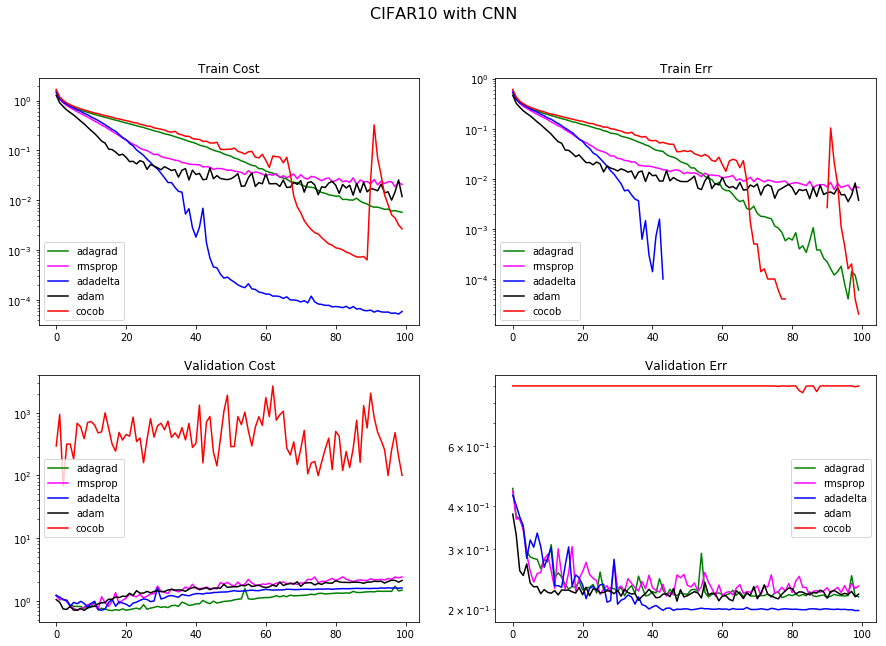

In [23]:
bs=128
num_epochs = 100
dl_train, dl_val = get_cifar10(bs)
results_3a = dict()
lr = {'adagrad': 0.01, 'rmsprop': 0.001, 'adadelta': 0.1, 'adam': 0.001}

for opt_name in optimizers:
    model = CNN_CIFAR10().cuda()
    opt = get_optimizer(model, opt_name, lr=lr)
    result = run_experiment(num_epochs, bs, model, opt, opt_name, dl_train, dl_val, flatten=False, verbose=False)
    results_3a[opt_name] = result
    
plot_graphs_all(results_3a, colors, 'CIFAR10 with CNN')

Now, let's increase the value of 'L' or epsilon and run the experiment:

Files already downloaded and verified
Files already downloaded and verified
Constructing adagrad
Running  adagrad
....................................................................................................Done in 324.54 secs
Constructing rmsprop
Running  rmsprop
....................................................................................................Done in 330.56 secs
Constructing adadelta
Running  adadelta
....................................................................................................Done in 339.40 secs
Constructing adam
Running  adam
....................................................................................................Done in 334.83 secs
Constructing cocob
Running  cocob
....................................................................................................Done in 346.53 secs


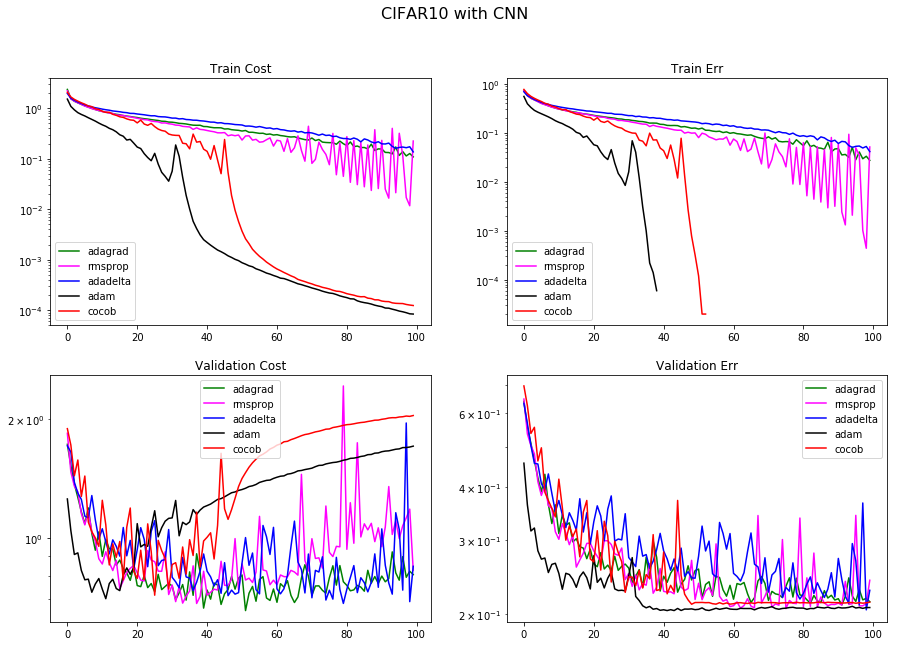

In [51]:
bs=1000
num_epochs = 100
dl_train, dl_val = get_cifar10(bs)
results_3b = dict()
lr = {'adagrad': 0.01, 'rmsprop': 0.001, 'adadelta': 0.1, 'adam': 0.001}

for opt_name in optimizers:
    model = CNN_CIFAR10().cuda()
    opt = get_optimizer(model, opt_name, lr=lr)
    if opt_name == 'cocob':
        opt = COCOBBackprop(model.parameters(), epsilon=1e-2)
    result = run_experiment(num_epochs, bs, model, opt, opt_name, dl_train, dl_val, flatten=False, verbose=False)
    results_3b[opt_name] = result
    
plot_graphs_all(results_3b, colors, 'CIFAR10 with CNN')

In [52]:
save_data('result_3a.pkl', results_3a)
save_data('result_3b.pkl', results_3b)

### To plot the graphs for README

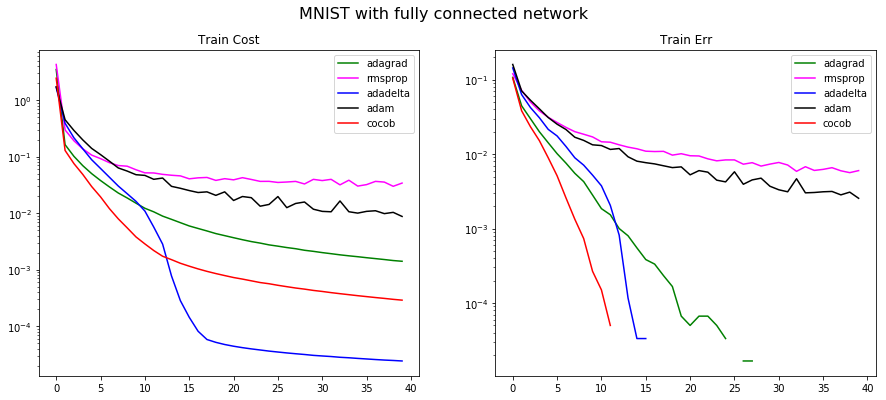

In [55]:
plot_graphs(results_1, colors, "MNIST with fully connected network")

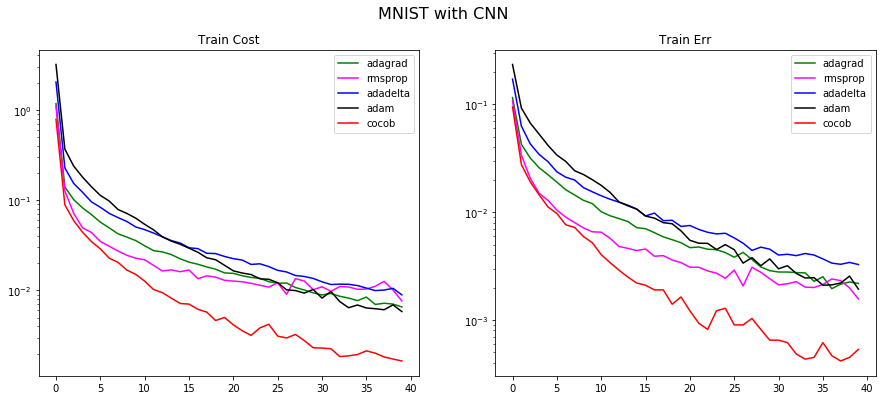

In [56]:
plot_graphs(results_2, colors, "MNIST with CNN")

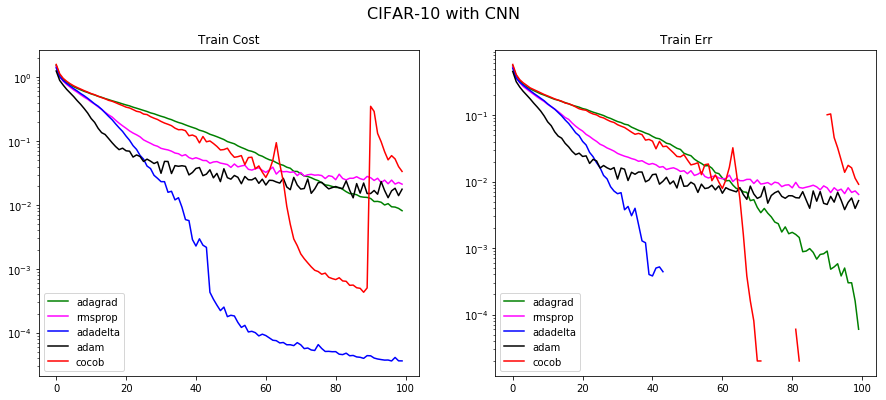

In [57]:
plot_graphs(results_3, colors, "CIFAR-10 with CNN")

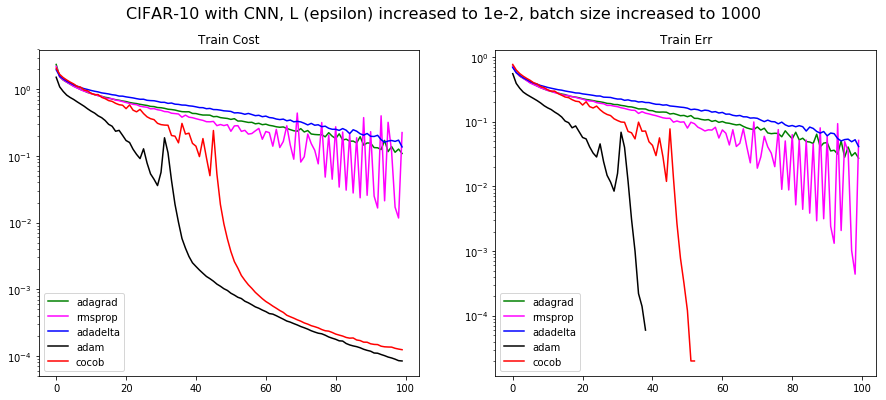

In [58]:
plot_graphs(results_3b, colors, "CIFAR-10 with CNN, L (epsilon) increased to 1e-2, batch size increased to 1000")